# FFN vs LogReg

#### on a synthetic dataset
#### N.B. Generative AI was used to generate the synthetic datasets

In [ ]:
!pip install gensim compress_fasttext

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.8 MB/s eta 0:00:00
  Created wheel for compress_fasttext: filename=compress_fasttext-0.1.5-py3-none-any.whl size=16098 sha256=3fcc4ef3a4fde239be8cfebdb464bccf48c712827af2d5009206aa232079bc4d
  Stored in directory: /root/.cache/pip/wheels/90/ed/77/0a7fc5e08ff30e062f09c6904844a5911a9e30a7e5ec376890
Successfully built compress_fasttext
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy

In [ ]:
import string
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from copy import deepcopy
import compress_fasttext

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_binary = [
    ("good", 1),
    ("bad", 0),
    ("awesome", 1),
    ("terrible", 0),
    ("great", 1),
    ("horrible", 0),
    ("excellent", 1),
    ("poor", 0),
    ("not good", 0),
    ("not bad", 1),
    ("not terrible", 1),
    ("not great", 0),
    ("not horrible", 1),
    ("not awesome", 0),
    ("not poor", 1),
    ("very good", 1),
    ("very bad", 0),
    ("very great", 1),
    ("very horrible", 0),
    ("not very good", 0),
    ("not very bad", 1),
    ("not very great", 0),
    ("not very horrible", 1),
    ("not very awesome", 0),
    ("not very poor", 1),
    ("good good", 1),
    ("bad bad", 0),
    ("not not bad", 0),
    ("not not good", 1),
    ("not not terrible", 0),
    ("not not awesome", 1),
    ("very very good", 1),
    ("very very bad", 0),
    ("good and bad", 0),
    ("bad and good", 0),
    ("awesome but terrible", 1),
    ("terrible but awesome", 1),
    ("good but not great", 0),
    ("great but not good", 1),
    ("not good but not bad", 1),
    ("not bad but not good", 0),
    ("excellent", 1),
    ("awful", 0),
    ("not awful", 1),
    ("not excellent", 0),
    ("very awful", 0),
    ("very excellent", 1),
    ("not very awful", 1),
    ("not very excellent", 0),
]

data_multiclass = [
    ("good", 2),
    ("bad", 0),
    ("awesome", 2),
    ("terrible", 0),
    ("great", 2),
    ("horrible", 0),
    ("excellent", 2),
    ("poor", 0),
    ("okay", 1),
    ("fine", 1),
    ("average", 1),
    ("not good", 0),
    ("not bad", 1),
    ("not terrible", 1),
    ("not great", 1),
    ("not horrible", 1),
    ("not awesome", 1),
    ("not poor", 1),
    ("very good", 2),
    ("very bad", 0),
    ("very great", 2),
    ("very horrible", 0),
    ("not very good", 1),
    ("not very bad", 1),
    ("not very great", 1),
    ("not very horrible", 1),
    ("not very awesome", 1),
    ("not very poor", 1),
    ("good good", 2),
    ("bad bad", 0),
    ("not not bad", 1),
    ("not not good", 2),
    ("not not terrible", 1),
    ("not not awesome", 2),
    ("very very good", 2),
    ("very very bad", 0),
    ("good and bad", 1),
    ("bad and good", 1),
    ("awesome but terrible", 1),
    ("terrible but awesome", 1),
    ("good but not great", 1),
    ("great but not good", 2),
    ("not good but not bad", 1),
    ("not bad but not good", 1),
    ("excellent", 2),
    ("awful", 0),
    ("not awful", 1),
    ("not excellent", 1),
    ("very awful", 0),
    ("very excellent", 2),
    ("not very awful", 1),
    ("not very excellent", 1),
]


In [ ]:
# raw data
X_bin, Y_bin = [p[0] for p in data_binary], np.array([[p[1]] for p in data_binary])
X_multi, Y_multi = [p[0] for p in data_multiclass], np.array([[p[1]] for p in data_multiclass])

# tfidf features = character n-grams
tfidf = TfidfVectorizer(ngram_range=(1,4), analyzer='char')
X_bin_transformed = tfidf.fit_transform(X_bin)
X_multi_transformed = tfidf.fit_transform(X_multi)


print(f'binary examples, features: {X_bin_transformed.shape}')
print(f'multiclass examples, features: {X_multi_transformed.shape}')

binary examples, features: (49, 255)
multiclass examples, features: (52, 280)


## Logistic Regression

### Binary

In [ ]:
lr = LogisticRegression(C=1, max_iter=20)
lr.fit(X_bin_transformed, Y_bin.ravel())
y_hat = lr.predict(X_bin_transformed)

print(f'f1-score on the set: {f1_score(Y_bin, y_hat)}')

f1-score on the set: 0.7272727272727273


### Multiclass

f1-score on the set: 0.8653846153846154


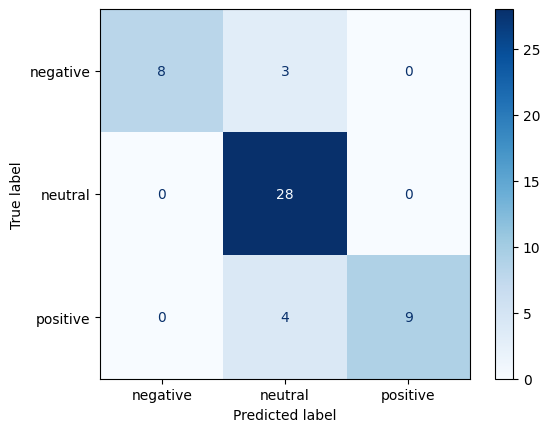

In [ ]:
lr = LogisticRegression(C=1, max_iter=20)
lr.fit(X_multi_transformed, Y_multi.ravel())
y_hat_multi = lr.predict(X_multi_transformed)

print(f'f1-score on the set: {f1_score(Y_multi, y_hat_multi, average="micro")}')

ConfusionMatrixDisplay(confusion_matrix(y_pred=y_hat_multi, y_true=Y_multi.ravel()), display_labels=['negative', 'neutral', 'positive']).plot(cmap=plt.cm.Blues)
plt.show()

## FFN

### Binary

In [ ]:
class FFN(nn.Module):
   def __init__(self, in_feats, hidden_size, out_classes):
       super(FFN, self).__init__()
       self.clf1 = nn.Linear(in_feats, hidden_size)
       self.relu = nn.ReLU()
       self.clf2 = nn.Linear(hidden_size, out_classes)
   def forward(self, X):
       return self.clf2(self.relu(self.clf1(X)))

In [ ]:
ffn = FFN(in_feats=X_bin_transformed.shape[1],hidden_size=32, out_classes=1)
opt = torch.optim.AdamW(ffn.parameters(), lr=0.05, weight_decay=1)
loss_fn = nn.BCEWithLogitsLoss()

X_bin_tensor = torch.tensor(X_bin_transformed.toarray(), dtype=torch.float32)
Y_bin_tensor = torch.tensor(Y_bin, dtype=torch.float32)

for epoch in range(20):
   opt.zero_grad()

   y_hat = ffn.forward(X_bin_tensor)
   loss = loss_fn(y_hat, Y_bin_tensor)
   loss.backward()
   opt.step()

   with torch.no_grad():
      y_hat_eval = [1 if torch.sigmoid(_) >= 0.5 else 0 for _ in y_hat]
      print(f'f1-score on the set: {f1_score(Y_bin_tensor, y_hat_eval)}')


f1-score on the set: 0.0
f1-score on the set: 0.7352941176470589
f1-score on the set: 0.7246376811594203
f1-score on the set: 0.711864406779661
f1-score on the set: 0.7692307692307693
f1-score on the set: 0.7755102040816326
f1-score on the set: 0.7843137254901961
f1-score on the set: 0.8333333333333334
f1-score on the set: 0.851063829787234
f1-score on the set: 0.851063829787234
f1-score on the set: 0.875
f1-score on the set: 0.8571428571428571
f1-score on the set: 0.92
f1-score on the set: 0.9411764705882353
f1-score on the set: 0.9803921568627451
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0


### Multiclass

f1-score on the set: 0.5576923076923077
f1-score on the set: 0.5384615384615384
f1-score on the set: 0.5384615384615384
f1-score on the set: 0.7115384615384616
f1-score on the set: 0.8653846153846154
f1-score on the set: 0.9038461538461539
f1-score on the set: 0.9615384615384616
f1-score on the set: 0.9615384615384616
f1-score on the set: 0.9615384615384616
f1-score on the set: 0.9615384615384616
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0
f1-score on the set: 1.0


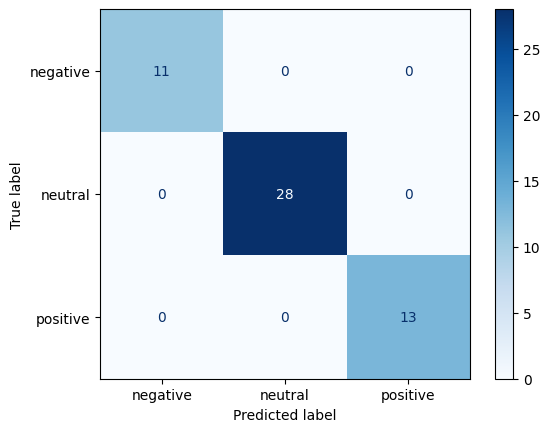

In [ ]:
ffn = FFN(in_feats=X_multi_transformed.shape[1],hidden_size=32, out_classes=3)
opt = torch.optim.AdamW(ffn.parameters(), lr=0.05, weight_decay=1)
loss_fn = nn.CrossEntropyLoss()

X_multi_tensor = torch.tensor(X_multi_transformed.toarray(), dtype=torch.float32)
Y_multi_tensor = torch.tensor(Y_multi, dtype=torch.long)

y_hat_multi_ffn = None
for epoch in range(20):
   opt.zero_grad()

   y_hat = ffn.forward(X_multi_tensor)
   loss = loss_fn(y_hat, Y_multi_tensor.squeeze(dim=1))
   loss.backward()
   opt.step()

   with torch.no_grad():
      y_hat_eval = torch.argmax(y_hat, dim=1)
      y_hat_multi_ffn = y_hat_eval
      print(f'f1-score on the set: {f1_score(Y_multi_tensor, y_hat_eval, average="micro")}')

ConfusionMatrixDisplay(confusion_matrix(y_pred=y_hat_multi_ffn, y_true=Y_multi.ravel()), display_labels=['negative', 'neutral', 'positive']).plot(cmap=plt.cm.Blues)
plt.show()

## With TF-IDF features

In [ ]:
df_train = pd.read_csv('train_data.csv', delimiter=',')
df_train['label'].value_counts()

,count
label,
2,128
0,90
1,22


In [ ]:
df_val = pd.read_csv('val_data.csv', delimiter=',')
df_val['label'].value_counts()

,count
label,
2,23
0,5
1,2


In [ ]:
df_test = pd.read_csv('test_data.csv', delimiter=',')
df_test['label'].value_counts()

,count
label,
2,17
0,12
1,1


### Transform to features

In [ ]:
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True, ngram_range=(1, 4), analyzer='word')

# too large sparse matrices would need dimensionality reduction
pca = TruncatedSVD(n_components=200)

X_train, Y_train = tfidf.fit_transform(list(df_train['text'])), torch.tensor(list(df_train['label']))
X_train = torch.tensor(pca.fit_transform(X_train), dtype=torch.float32)

X_val, Y_val = tfidf.transform(list(df_val['text'])), torch.tensor(list(df_val['label']))
X_val = torch.tensor(pca.transform(X_val), dtype=torch.float32)

X_test, Y_test = tfidf.transform(list(df_test['text'])), torch.tensor(list(df_test['label']))
X_test = torch.tensor(pca.transform(X_test), dtype=torch.float32)


print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([240, 200]) torch.Size([30, 200]) torch.Size([30, 200])


### Evaluation

In [ ]:
def compute_metrics(y_true, y_pred):
    try:
        y_true = y_true.cpu()
        y_pred = y_pred.cpu()
    except AttributeError:
        pass

    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')

    return precision, recall, f1

### Logistic Regression

In [ ]:
logistic_regression = LogisticRegression(C=1, max_iter=50)
logistic_regression.fit(X_train, Y_train)
y_hat = logistic_regression.predict(X_test)

print(compute_metrics(Y_test, y_hat))

(0.6333333333333333, 0.6333333333333333, 0.6333333333333333)


### FFN

100%|██████████| 50/50 [00:00<00:00, 287.16it/s]


epoch: 10 loss: 0.03673012554645538 dev f1-micro: 0.6666666666666666
epoch: 20 loss: 0.0013634557835757732 dev f1-micro: 0.6333333333333333
epoch: 30 loss: 0.0009346402948722243 dev f1-micro: 0.6666666666666666
epoch: 40 loss: 0.003272414207458496 dev f1-micro: 0.6
epoch: 50 loss: 0.004629149101674557 dev f1-micro: 0.6
test precision-micro: 0.7333333333333333 test recall-micro: 0.7333333333333333 test f1-micro: 0.7333333333333333


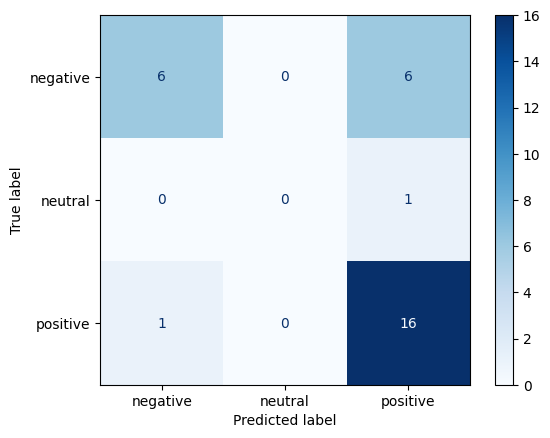

In [ ]:
class FFN(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(FFN, self).__init__()
        self.lin1 = nn.Linear(in_feats, hidden_size)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_size, out_feats)

    def forward(self, X):
        return self.lin2(self.relu(self.lin1(X)))


in_feats = X_train.shape[1]
hidden_size = in_feats * 2
out_feats = 3
epochs = 50
lr = 0.03

ffn = FFN(in_feats, hidden_size, out_feats).to(device)
optimizer = torch.optim.AdamW(ffn.parameters(), lr, weight_decay=1)
loss_fn = nn.CrossEntropyLoss()

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    y_hat = ffn.forward(X_train.to(device))
    loss = loss_fn(y_hat, Y_train.to(device))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
      with torch.no_grad():
          _, _, f1 = compute_metrics(Y_val.to(device), torch.argmax(ffn.forward(X_val.to(device)), dim=1))
          print(f'epoch: {epoch + 1} loss: {loss.item()} dev f1-micro: {f1}')

with torch.no_grad():
    y_hat = torch.argmax(ffn.forward(X_test.to(device)), dim=1).cpu()
    p, r, f1 = compute_metrics(Y_test, y_hat)
    print(f'test precision-micro: {p} test recall-micro: {r} test f1-micro: {f1}')

    ConfusionMatrixDisplay(confusion_matrix(y_pred=y_hat, y_true=Y_test),display_labels=['negative', 'neutral', 'positive']).plot(cmap=plt.cm.Blues)
    plt.show()


## With Embeddings

### Pretrained Embeddings

In [ ]:
embeddings = compress_fasttext.models.CompressedFastTextKeyedVectors.load("cc.en.300.compressed.bin")

### Embedding Matrix

In [ ]:
vocab = {'<UNK>': 0, '<PAD>': 1}

for i, w in enumerate(embeddings.index_to_key):
    vocab[w] = i + 2

emb = np.zeros((len(vocab), 300))
for w, i in vocab.items():
    # fasttext models build representation from n-grams for OOV words
    emb[i] = embeddings[w]
emb = torch.tensor(emb, dtype=torch.float32)

id2label = {0 : 'negative', 1 : 'neutral', 2 : 'positive'}
id2word = {v: k for k, v in vocab.items()}

print(emb.shape)

torch.Size([20002, 300])


### We can design the max_seq_len by exploring the average length of the documents

In [ ]:
def avg_tokens(df):

    tokens_all = 0
    for text in df['text']:
      # the same tokenization strategy used with preprocessing the data
      tokens = text.strip().lower().split(' ')
      num_tokens = len([token for token in tokens if token not in string.punctuation and len(token) >= 3])
      tokens_all += num_tokens
    avg = tokens_all / len(df['text'])

    return round(avg)
avg_tokens(df_train), avg_tokens(df_val), avg_tokens(df_test)

(11, 10, 8)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # tokens = self.texts[idx].strip().lower().split(' ')
        # tokens = [token for token in tokens if token not in string.punctuation and len(token) >= 3]
        text = self.texts[idx].strip()
        tokens = text.lower().translate(str.maketrans('', '', string.punctuation)).replace('\s+',' ').split()
        ### remember now we are using our vocab, not the model anymore - therefore we learn <UNK> token for OOV words

        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        if len(indices) < self.max_len:
            indices += [self.vocab['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]


        return torch.tensor(indices), torch.tensor(self.labels[idx], dtype=torch.long)
# batch size x max seq length x input features
# (32, 10, 300)
train_dataset = SentimentDataset(texts=list(df_train['text']), labels=list(df_train['label']),vocab=vocab,
                                 max_len=10)
train_loader = DataLoader(train_dataset, batch_size=32)

val_dataset = SentimentDataset(texts=list(df_val['text']), labels=list(df_val['label']),  vocab=vocab,
                               max_len=10)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = SentimentDataset(texts=list(df_test['text']), labels=list(df_test['label']), vocab=vocab,
                                max_len=10)
test_loader = DataLoader(test_dataset, batch_size=32)

### Logistic Regression

In [ ]:
def to_sklearn_format(data_loader):
  X, Y = [], []
  for examples, labels in data_loader:
      assert len(examples) == len(labels)
      n = len(examples)
      sent_mean_embeddings = []
      for i in range(n):
        example, label = examples[i], labels[i]
        embedding_sent = torch.stack([emb[idx] for idx in example], dim=0)
        sent_mean = torch.mean(embedding_sent, dim=1)
        X.append(np.array(sent_mean))
        Y.append(label.item())
  return X, Y

X_train, Y_train = to_sklearn_format(train_loader)
X_test, Y_test = to_sklearn_format(test_loader)

logreg = LogisticRegression(max_iter=100, C=1)
logreg.fit(X_train, Y_train)
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)


print(f'fit on train set: {f1_score(Y_train, y_hat_train, average="micro")}\n \
        fit on test set: {f1_score(Y_test, y_hat_test, average="micro")}')

fit on train set: 0.5333333333333333
         fit on test set: 0.5666666666666667


### Feed-Forward Network

In [ ]:
class FFN(nn.Module):
    def __init__(self, emb_matrix, in_feats, hidden_size, emb_size, out_feats):
        super(FFN, self).__init__()
        self.embedding = nn.Embedding(in_feats, emb_size)
        self.embedding.weight = nn.Parameter(emb_matrix)
        self.lin1 = nn.Linear(emb_size, hidden_size)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_size,  out_feats)
    def forward(self, X):
        e = self.embedding(X)
        e_mean = e.mean(dim=1)
        # classification head
        out = self.lin2(self.relu(self.lin1(e_mean)))

        return out


### Trainer

In [ ]:
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')

    return precision, recall, f1


device = 'cuda' if torch.cuda.is_available() else 'cpu'

### hyperparameters
in_feats = len(vocab)
hidden_size = 2056
emb_size = 300
out_classes = 3
epochs = 30
early_stopping = 30
lr = 0.01
weight_decay = 1
model_name = 'best-model-bin'

### neural net
ffn = FFN(emb_matrix = emb, in_feats=len(vocab), hidden_size=hidden_size, emb_size=emb_size, out_feats=out_classes).to(device)

### optimizer - AdamW = architectural variant of Gradient Descent
opt = torch.optim.AdamW(ffn.parameters(), lr=lr, weight_decay=weight_decay)

### loss function
### 1. Binary Classification - BCELoss(), BCEWithLogitsLoss, target float
### difference - needs sigmoid/internal sigmoid

### 2. Multi Class Classification - NLLLoss(), CrossEntropyLoss(), target long
### difference - needs softmax/internal softmax


loss_fn = torch.nn.CrossEntropyLoss()

best_f1, best_model_dict, bestloss = 0.0, None, 0.0
tolerance = early_stopping

for epoch in tqdm(range(epochs), desc='Training Started'):
    epoch_loss = []
    for x, y in train_loader:
        opt.zero_grad()
        y = y.to(device)


        y_hat = ffn(x.to(device))
        loss = loss_fn(y_hat, y)

        epoch_loss.append(loss.item())
        loss.backward()

        opt.step()


    ### evaluation every epoch
    ### on dev set
    y_true, y_pred = [], []
    with torch.no_grad():
      for examples, y in val_loader:
          y_hat = ffn(examples.to(device))
          y_true.extend([_.item() for _ in y])
          y_pred.extend(list(torch.argmax(y_hat, dim=1).cpu()))

    p, r, f1 = compute_metrics(y_true, y_pred)

    if best_f1 < f1:
        best_f1 = f1
        best_model_dict = deepcopy(ffn.state_dict())
        tolerance = early_stopping
        bestloss = sum(epoch_loss) / len(epoch_loss)
    else:
        tolerance -= 1
        if tolerance == 0:
            print(f'no improvement for {early_stopping} epochs')
            break

    print(f'epoch: {epoch + 1} '
          f'loss: {sum(epoch_loss) / len(epoch_loss)}\n'
          f'metrics: {p, r, f1}')



Training Started:   3%|▎         | 1/30 [00:01<00:31,  1.10s/it]

epoch: 1 loss: 0.9339655116200447
metrics: (0.23333333333333334, 0.23333333333333334, 0.23333333333333334)


Training Started:   7%|▋         | 2/30 [00:02<00:28,  1.00s/it]

epoch: 2 loss: 0.7062412351369858
metrics: (0.3, 0.3, 0.3)


Training Started:  10%|█         | 3/30 [00:02<00:26,  1.03it/s]

epoch: 3 loss: 0.38035026006400585
metrics: (0.6666666666666666, 0.6666666666666666, 0.6666666666666666)


Training Started:  13%|█▎        | 4/30 [00:03<00:24,  1.06it/s]

epoch: 4 loss: 0.16277129482477903
metrics: (0.26666666666666666, 0.26666666666666666, 0.26666666666666666)


Training Started:  17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

epoch: 5 loss: 0.06839274615049362
metrics: (0.5666666666666667, 0.5666666666666667, 0.5666666666666667)


Training Started:  20%|██        | 6/30 [00:05<00:21,  1.09it/s]

epoch: 6 loss: 0.037218105208012275
metrics: (0.43333333333333335, 0.43333333333333335, 0.43333333333333335)


Training Started:  23%|██▎       | 7/30 [00:06<00:22,  1.04it/s]

epoch: 7 loss: 0.02319076194180525
metrics: (0.6, 0.6, 0.6)


Training Started:  27%|██▋       | 8/30 [00:08<00:23,  1.09s/it]

epoch: 8 loss: 0.02223618220887147
metrics: (0.5, 0.5, 0.5)


Training Started:  30%|███       | 9/30 [00:09<00:23,  1.12s/it]

epoch: 9 loss: 0.017745678589562885
metrics: (0.5, 0.5, 0.5)


Training Started:  33%|███▎      | 10/30 [00:10<00:21,  1.06s/it]

epoch: 10 loss: 0.017558307445142418
metrics: (0.43333333333333335, 0.43333333333333335, 0.43333333333333335)


Training Started:  37%|███▋      | 11/30 [00:11<00:19,  1.01s/it]

epoch: 11 loss: 0.01445173881802475
metrics: (0.43333333333333335, 0.43333333333333335, 0.43333333333333335)


Training Started:  40%|████      | 12/30 [00:11<00:17,  1.02it/s]

epoch: 12 loss: 0.016307448626321275
metrics: (0.43333333333333335, 0.43333333333333335, 0.43333333333333335)


Training Started:  43%|████▎     | 13/30 [00:12<00:16,  1.05it/s]

epoch: 13 loss: 0.013898781602620147
metrics: (0.4, 0.4, 0.4)


Training Started:  47%|████▋     | 14/30 [00:13<00:15,  1.07it/s]

epoch: 14 loss: 0.013565075878432253
metrics: (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)


Training Started:  50%|█████     | 15/30 [00:14<00:14,  1.07it/s]

epoch: 15 loss: 0.015010852555860765
metrics: (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)


Training Started:  53%|█████▎    | 16/30 [00:15<00:13,  1.07it/s]

epoch: 16 loss: 0.011546662211912917
metrics: (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)


Training Started:  57%|█████▋    | 17/30 [00:16<00:12,  1.08it/s]

epoch: 17 loss: 0.021097431341331685
metrics: (0.3, 0.3, 0.3)


Training Started:  60%|██████    | 18/30 [00:17<00:11,  1.08it/s]

epoch: 18 loss: 0.02663776371628046
metrics: (0.4666666666666667, 0.4666666666666667, 0.4666666666666667)


Training Started:  63%|██████▎   | 19/30 [00:18<00:10,  1.09it/s]

epoch: 19 loss: 0.03935843758517876
metrics: (0.5333333333333333, 0.5333333333333333, 0.5333333333333333)


Training Started:  67%|██████▋   | 20/30 [00:19<00:09,  1.02it/s]

epoch: 20 loss: 0.0973440958186984
metrics: (0.5333333333333333, 0.5333333333333333, 0.5333333333333333)


Training Started:  70%|███████   | 21/30 [00:20<00:09,  1.11s/it]

epoch: 21 loss: 0.2793226111680269
metrics: (0.43333333333333335, 0.43333333333333335, 0.43333333333333335)


Training Started:  73%|███████▎  | 22/30 [00:21<00:08,  1.10s/it]

epoch: 22 loss: 0.21918680879753083
metrics: (0.5333333333333333, 0.5333333333333333, 0.5333333333333333)


Training Started:  77%|███████▋  | 23/30 [00:22<00:07,  1.04s/it]

epoch: 23 loss: 0.11699550226330757
metrics: (0.6, 0.6, 0.6)


Training Started:  80%|████████  | 24/30 [00:23<00:06,  1.00s/it]

epoch: 24 loss: 0.130003024591133
metrics: (0.5, 0.5, 0.5)


Training Started:  83%|████████▎ | 25/30 [00:24<00:04,  1.03it/s]

epoch: 25 loss: 0.055018415878294036
metrics: (0.5333333333333333, 0.5333333333333333, 0.5333333333333333)


Training Started:  87%|████████▋ | 26/30 [00:25<00:03,  1.05it/s]

epoch: 26 loss: 0.09652552099396416
metrics: (0.6, 0.6, 0.6)


Training Started:  90%|█████████ | 27/30 [00:26<00:02,  1.07it/s]

epoch: 27 loss: 0.03148869250435382
metrics: (0.5, 0.5, 0.5)


Training Started:  93%|█████████▎| 28/30 [00:27<00:01,  1.08it/s]

epoch: 28 loss: 0.021812271559610963
metrics: (0.4666666666666667, 0.4666666666666667, 0.4666666666666667)


Training Started:  97%|█████████▋| 29/30 [00:28<00:00,  1.09it/s]

epoch: 29 loss: 0.016490115915075876
metrics: (0.5, 0.5, 0.5)


Training Started: 100%|██████████| 30/30 [00:29<00:00,  1.03it/s]

epoch: 30 loss: 0.015062738180859014
metrics: (0.5, 0.5, 0.5)


### Save

In [ ]:
torch.save({'state_dict': best_model_dict, 'embeddings': deepcopy(emb), 'epochs': epochs,
            'early_stopping': early_stopping, 'loss': bestloss,
            'loss_fn': loss_fn.__class__.__name__,
            'optimizer': opt.__class__.__name__,
            'in_feats': in_feats, 'hidden_size': hidden_size, 'out_feats': out_classes, 'lr': lr,
            'test_loader': deepcopy(test_loader)},
           f'{model_name}-fasttext.pt')

### Evaluate

In [ ]:
model_saved = torch.load('best-model-bin-fasttext.pt', weights_only=False, map_location=device)
ffn.load_state_dict(model_saved['state_dict'])

with torch.no_grad():
    y_true, y_pred = [], []
    for examples_test, y_test in test_loader:
        y_hat = ffn.forward(examples_test.to(device))
        y_true.extend([_.item() for _ in y_test])
        y_pred.extend(list(torch.argmax(y_hat, dim=1).cpu()))

print('predicted', [id2label[id.item()] for id in y_pred])
print('gold', [id2label[id] for id in y_true])

compute_metrics(y_true, y_pred)

predicted ['positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative']
gold ['positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'neutral', 'positive', 'negative', 'positive', 'negative', 'negative']


(0.6333333333333333, 0.6333333333333333, 0.6333333333333333)

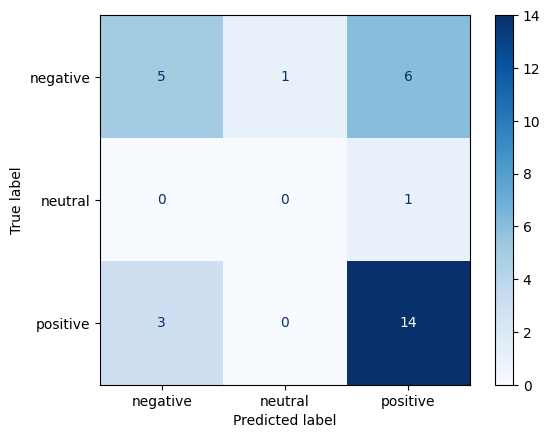

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=list(id2label.values())).plot(
    cmap=plt.cm.Blues)
plt.show()